<a href="https://colab.research.google.com/github/InduwaraGayashan001/PyTorch/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install -q torchinfo

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import datasets
from torchvision.transforms import v2 as transforms
from torchvision.ops import Conv2dNormActivation

from dataclasses import dataclass
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sn

import matplotlib.pyplot as plt
import time
import numpy as np
import random
import warnings
import os
from tqdm import tqdm

import pandas as pd

%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
#Set seed for reproducibilty
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
       torch.cuda.manual_seed(seed)
       torch.cuda.manual_seed_all(seed)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = True

set_seed(42)

# Extract Data

In [4]:
!wget -q "https://www.dropbox.com/s/45jdd8padeyjq6t/10_Monkey_Species.zip?dl=1" -O "10_Monkey_Species.zip"


In [5]:
!unzip -q "10_Monkey_Species.zip"

# Configurations

In [6]:
@dataclass(frozen=True)
class TrainingConfig:
      ''' Configuration for Training '''
      batch_size: int = 32
      num_epochs: int = 100
      learning_rate: float = 1e-4

      log_interval: int = 1
      test_interval: int = 1
      data_root: int = "./"
      num_workers: int = 5
      device: str = "cuda"

train_config = TrainingConfig()
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
print("Available Device: ", DEVICE)

Available Device:  cuda


# Load Data

In [7]:
train_root = os.path.join("10_Monkey_Species", "training", "training")
val_root = os.path.join(train_config.data_root, "10_Monkey_Species", "validation", "validation")

In [8]:
df = pd.read_csv(os.path.join("10_Monkey_Species","monkey_labels.txt"), sep=",", header=None)
df.columns = ["Label", "Latin Name", "Common Name", "Train Images", "Validation Images"]
df['Latin Name'] = df['Latin Name'].str.replace("\t", " ")
df[1:]

,Label,Latin Name,Common Name,Train Images,Validation Images
1,n0,alouatta_palliata,mantled_howler,131,26
2,n1,erythrocebus_patas,patas_monkey,139,28
3,n2,cacajao_calvus,bald_uakari,137,27
4,n3,macaca_fuscata,japanese_macaque,152,30
5,n4,cebuella_pygmea,pygmy_marmoset,131,26
6,n5,cebus_capucinus,white_headed_capuchin,141,28
7,n6,mico_argentatus,silvery_marmoset,132,26
8,n7,saimiri_sciureus,common_squirrel_monkey,142,28
9,n8,aotus_nigriceps,black_headed_night_monkey,133,27
10,n9,trachypithecus_johnii,nilgiri_langur,132,26


# Data  Preprocessing

In [9]:
mean = [0.4368, 0.4336, 0.3294]
std = [0.2457, 0.2413, 0.2447]


img_size = (224,224)

preprocess = transforms.Compose(
    [
        transforms.Resize(img_size, antialias=True),
        transforms.ToTensor()
    ]
)

# Data Augmentation
train_transforms = transforms.Compose(
    [
        preprocess,
        transforms.RandomHorizontalFlip(),
        transforms.RandomErasing(p=0.4),
        transforms.RandomApply([
        transforms.RandomAffine(degrees=(30,70), translate=(0.1,0.3), scale=(0.5,0.75)),
        ], p = 0.1),
        transforms.Normalize(mean = mean , std =std)
    ]
)

val_transforms = transforms.Compose(
    [
        preprocess,
        transforms.Normalize(mean, std)
    ]
)

In [10]:
train_data = datasets.ImageFolder(root = train_root, transform = train_transforms)
val_data = datasets.ImageFolder(root = val_root, transform = val_transforms)

In [11]:
train_loader = DataLoader(
    train_data,
    batch_size = train_config.batch_size,
    shuffle = True,
    num_workers = train_config.num_workers,
)

val_loader = DataLoader(
    val_data,
    batch_size = train_config.batch_size,
    shuffle = False,
    num_workers = train_config.num_workers,
)

In [12]:
len(next(iter(train_loader)))

2

In [13]:
class_mapping = {

    0: "mantled_howler",
    1: "patas_monkey",
    2: "bald_uakari",
    3: "japanese_macaque",
    4: "pygmy_marmoset",
    5: "white_headed_capuchin",
    6: "silvery_marmoset",
    7: "common_squirrel_monkey",
    8: "black_headed_night_monkey",
    9: "nilgiri_langur"
}

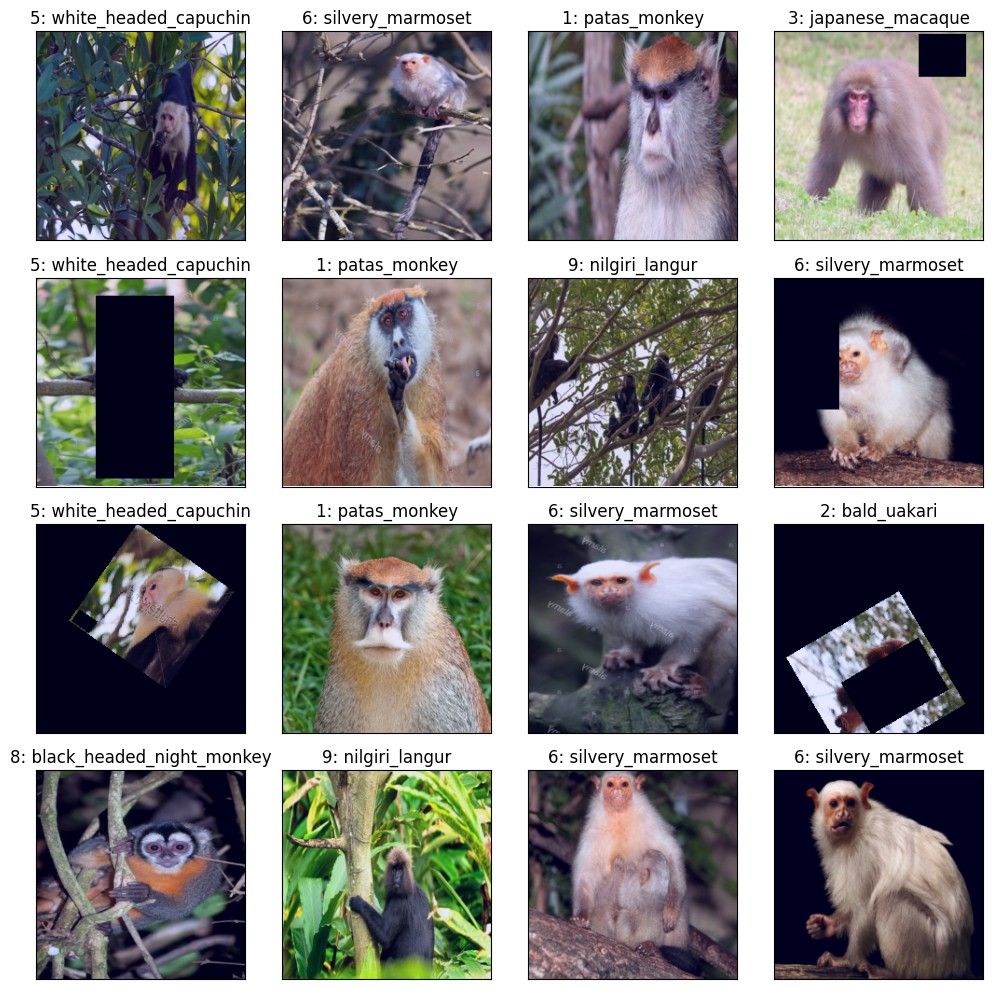

In [14]:
def visualize_images(dataloader, num_images = 20):
    fig = plt.figure(figsize=(10,10))

    #Iterate over the first batch
    images, labels = next(iter(dataloader))
    # print(images.shape)

    num_rows = 4
    num_cols = int(np.ceil((num_images / num_rows)))

    for idx in range(min(num_images, len(images))):
        image, label = images[idx], labels[idx]


        ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks = [], yticks = [])

        image = image.permute(1,2,0)

        #Normalize the image to [0,1] to display

        image = (image - image.min()) / (image.max() - image.min())
        ax.imshow(image, cmap="gray")  # remove the batch dimension
        ax.set_title(f"{label.item()}: {class_mapping[label.item()]}")

    fig.tight_layout()
    plt.show()

visualize_images(train_loader, num_images = 16)

# CNN Model Implementation

In [15]:
class CNN(nn.Module):

  def __init__(self):
      super().__init__()

      self.model = nn.Sequential(

          # Conv2d Norm Activation Block1: 32 Filters, MaxPool.
          Conv2dNormActivation(in_channels=3, out_channels=32, kernel_size=5),
          Conv2dNormActivation(in_channels=32, out_channels=32, kernel_size=3),
          nn.MaxPool2d(kernel_size=2),

          # Conv2d Norm Activation Block 2: 64,128 Filters, MaxPool, Dropout(p=0.25)
          Conv2dNormActivation(in_channels=32, out_channels=64, kernel_size=3),
          Conv2dNormActivation(in_channels=64, out_channels=128, kernel_size=3),
          nn.MaxPool2d(kernel_size=2),
          nn.Dropout(p=0.25),

          # Conv2d Norm Activation Block 3: 128,256,512 Filters, MaxPool.
          Conv2dNormActivation(in_channels=128, out_channels=256, kernel_size=3),
          Conv2dNormActivation(in_channels=256, out_channels=256, kernel_size=3),
          nn.MaxPool2d(kernel_size=2),
          Conv2dNormActivation(in_channels=256, out_channels=512, kernel_size=3),
          nn.MaxPool2d(kernel_size=2),

          # Feed Forward Layers
          nn.AdaptiveAvgPool2d(output_size=(3,3)),
          nn.Flatten(),

          # Classification Head
          nn.Linear(in_features=512*3*3, out_features=256),
          nn.Linear(in_features=256, out_features=10)
      )

  def forward(self, x):
      return self.model(x)


In [16]:
model = CNN()

optimizer = Adam(model.parameters(), lr = train_config.learning_rate)
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
logdir = "runs/80epochs-3.3M_param_dropout"
writer = SummaryWriter(logdir)

print(summary(model, input_size=(1, 3, 224, 224), row_settings=("var_names",), device='cpu'))


Layer (type (var_name))                  Output Shape              Param #
CNN (CNN)                                [1, 10]                   --
├─Sequential (model)                     [1, 10]                   --
│    └─Conv2dNormActivation (0)          [1, 32, 224, 224]         --
│    │    └─Conv2d (0)                   [1, 32, 224, 224]         2,400
│    │    └─BatchNorm2d (1)              [1, 32, 224, 224]         64
│    │    └─ReLU (2)                     [1, 32, 224, 224]         --
│    └─Conv2dNormActivation (1)          [1, 32, 224, 224]         --
│    │    └─Conv2d (0)                   [1, 32, 224, 224]         9,216
│    │    └─BatchNorm2d (1)              [1, 32, 224, 224]         64
│    │    └─ReLU (2)                     [1, 32, 224, 224]         --
│    └─MaxPool2d (2)                     [1, 32, 112, 112]         --
│    └─Conv2dNormActivation (3)          [1, 64, 112, 112]         --
│    │    └─Conv2d (0)                   [1, 64, 112, 112]         18,432
│    

# Training

In [21]:
def train(model, train_loader):
  model.train()
  model.to(DEVICE)

  running_loss = 0
  correct_predictions = 0
  total_train_samples = 0

  for images, labels in tqdm(train_loader, desc="Training"):
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    optimizer.zero_grad()
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, preds = torch.max(outputs.data, dim=1)
    total_train_samples += labels.shape[0]
    correct_predictions += (preds == labels).sum().item()

  train_loss = running_loss / len(train_loader)
  train_accuracy = 100 * correct_predictions / total_train_samples

  return train_loss, train_accuracy


In [22]:
def validate(model, val_loader):
  model.eval()
  model.to(DEVICE)

  running_loss = 0
  correct_predictions = 0
  total_val_samples = 0

  for images, labels in tqdm(val_loader, desc="Validation"):
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    with torch.no_grad():
      outputs = model(images)

    loss = F.cross_entropy(outputs, labels)
    running_loss += loss.item()
    _, preds = torch.max(outputs.data, dim=1)
    total_val_samples += labels.shape[0]
    correct_predictions += (preds == labels).sum().item()

  val_loss = running_loss / len(val_loader)
  val_accuracy = 100 * correct_predictions / total_val_samples

  return val_loss, val_accuracy

In [23]:
def main(model, train_loader, val_loader):

  train_losses, train_accuracies = [], []
  val_losses, val_accuracies = [], []

  best_val_acc = 0.0
  best_weights = None

  for epoch in range(train_config.num_epochs):
    train_loss, train_accuracy = train(model, train_loader)
    val_loss, val_accuracy = validate(model, val_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1:0>2}/{train_config.num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    writer.add_scalar("Loss/train", train_loss)
    writer.add_scalar("Loss/val", val_loss)
    writer.add_scalar("Accuracy/train", train_accuracy)
    writer.add_scalar("Accuracy/val", val_accuracy)

    if val_accuracy > best_val_acc:
      best_val_acc = val_accuracy
      best_weights = model.state_dict()
      print(f"Saving best model...💾")
      torch.save(best_weights, "best.pt")


  return train_losses, train_accuracies, val_losses, val_accuracies


In [24]:
train_losses, train_accuracies, val_losses, val_accuracies = main(model, train_loader, val_loader)

Validation: 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]


Epoch 01/100 - Train Loss: 1.5076, Train Accuracy: 46.31% - Val Loss: 1.4388, Val Accuracy: 47.79%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.70it/s]


Epoch 02/100 - Train Loss: 1.3386, Train Accuracy: 53.05% - Val Loss: 1.3240, Val Accuracy: 58.09%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


Epoch 03/100 - Train Loss: 1.2244, Train Accuracy: 58.16% - Val Loss: 1.2133, Val Accuracy: 57.35%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]


Epoch 04/100 - Train Loss: 1.1173, Train Accuracy: 60.98% - Val Loss: 1.1727, Val Accuracy: 59.19%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


Epoch 05/100 - Train Loss: 1.0764, Train Accuracy: 62.99% - Val Loss: 1.1285, Val Accuracy: 63.60%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.53it/s]


Epoch 06/100 - Train Loss: 1.0451, Train Accuracy: 63.54% - Val Loss: 1.1809, Val Accuracy: 62.87%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


Epoch 07/100 - Train Loss: 0.9714, Train Accuracy: 66.73% - Val Loss: 1.1213, Val Accuracy: 61.03%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]


Epoch 08/100 - Train Loss: 0.9091, Train Accuracy: 70.56% - Val Loss: 0.9217, Val Accuracy: 64.34%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]


Epoch 09/100 - Train Loss: 0.9267, Train Accuracy: 68.28% - Val Loss: 0.9688, Val Accuracy: 63.60%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


Epoch 10/100 - Train Loss: 0.8863, Train Accuracy: 71.56% - Val Loss: 1.0152, Val Accuracy: 65.44%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.58it/s]


Epoch 11/100 - Train Loss: 0.8215, Train Accuracy: 72.20% - Val Loss: 0.9433, Val Accuracy: 66.54%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


Epoch 12/100 - Train Loss: 0.7769, Train Accuracy: 73.20% - Val Loss: 0.9266, Val Accuracy: 69.85%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.64it/s]


Epoch 13/100 - Train Loss: 0.7751, Train Accuracy: 72.65% - Val Loss: 0.8586, Val Accuracy: 70.96%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


Epoch 14/100 - Train Loss: 0.7301, Train Accuracy: 76.75% - Val Loss: 0.9457, Val Accuracy: 68.75%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


Epoch 15/100 - Train Loss: 0.7495, Train Accuracy: 74.29% - Val Loss: 0.9131, Val Accuracy: 70.59%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


Epoch 16/100 - Train Loss: 0.7376, Train Accuracy: 75.84% - Val Loss: 0.8216, Val Accuracy: 72.43%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


Epoch 17/100 - Train Loss: 0.6627, Train Accuracy: 78.21% - Val Loss: 0.8622, Val Accuracy: 70.22%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


Epoch 18/100 - Train Loss: 0.6461, Train Accuracy: 76.85% - Val Loss: 0.8102, Val Accuracy: 72.79%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]


Epoch 19/100 - Train Loss: 0.5946, Train Accuracy: 80.22% - Val Loss: 0.8367, Val Accuracy: 72.06%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]


Epoch 20/100 - Train Loss: 0.6566, Train Accuracy: 77.48% - Val Loss: 0.9220, Val Accuracy: 70.96%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.62it/s]


Epoch 21/100 - Train Loss: 0.5832, Train Accuracy: 79.31% - Val Loss: 0.7287, Val Accuracy: 75.00%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]


Epoch 22/100 - Train Loss: 0.5622, Train Accuracy: 81.68% - Val Loss: 0.8133, Val Accuracy: 73.53%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.53it/s]


Epoch 23/100 - Train Loss: 0.5906, Train Accuracy: 80.04% - Val Loss: 0.9684, Val Accuracy: 70.96%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


Epoch 24/100 - Train Loss: 0.5139, Train Accuracy: 83.77% - Val Loss: 0.7963, Val Accuracy: 73.53%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.52it/s]


Epoch 25/100 - Train Loss: 0.5373, Train Accuracy: 81.77% - Val Loss: 0.8226, Val Accuracy: 72.06%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


Epoch 26/100 - Train Loss: 0.5330, Train Accuracy: 82.86% - Val Loss: 0.8301, Val Accuracy: 76.10%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


Epoch 27/100 - Train Loss: 0.5218, Train Accuracy: 80.77% - Val Loss: 0.7425, Val Accuracy: 75.00%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


Epoch 28/100 - Train Loss: 0.4868, Train Accuracy: 84.23% - Val Loss: 0.8447, Val Accuracy: 77.21%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]


Epoch 29/100 - Train Loss: 0.4984, Train Accuracy: 82.22% - Val Loss: 0.7364, Val Accuracy: 77.94%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


Epoch 30/100 - Train Loss: 0.4369, Train Accuracy: 85.14% - Val Loss: 0.8017, Val Accuracy: 75.74%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


Epoch 31/100 - Train Loss: 0.4213, Train Accuracy: 86.05% - Val Loss: 0.7559, Val Accuracy: 77.94%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.54it/s]


Epoch 32/100 - Train Loss: 0.3811, Train Accuracy: 87.60% - Val Loss: 0.8218, Val Accuracy: 74.63%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]


Epoch 33/100 - Train Loss: 0.4139, Train Accuracy: 85.69% - Val Loss: 0.7815, Val Accuracy: 76.47%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.48it/s]


Epoch 34/100 - Train Loss: 0.3818, Train Accuracy: 86.78% - Val Loss: 0.7255, Val Accuracy: 79.04%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.58it/s]


Epoch 35/100 - Train Loss: 0.3297, Train Accuracy: 88.70% - Val Loss: 0.9015, Val Accuracy: 73.16%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Epoch 36/100 - Train Loss: 0.4150, Train Accuracy: 85.14% - Val Loss: 0.7658, Val Accuracy: 78.68%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]


Epoch 37/100 - Train Loss: 0.3901, Train Accuracy: 86.60% - Val Loss: 0.8406, Val Accuracy: 77.21%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]


Epoch 38/100 - Train Loss: 0.3619, Train Accuracy: 87.06% - Val Loss: 0.6869, Val Accuracy: 76.84%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


Epoch 39/100 - Train Loss: 0.3259, Train Accuracy: 89.24% - Val Loss: 0.8018, Val Accuracy: 76.84%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]


Epoch 40/100 - Train Loss: 0.3951, Train Accuracy: 87.42% - Val Loss: 0.8292, Val Accuracy: 77.57%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]


Epoch 41/100 - Train Loss: 0.3670, Train Accuracy: 87.69% - Val Loss: 0.7153, Val Accuracy: 78.31%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]


Epoch 42/100 - Train Loss: 0.3539, Train Accuracy: 87.60% - Val Loss: 0.7947, Val Accuracy: 77.21%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.63it/s]


Epoch 43/100 - Train Loss: 0.3764, Train Accuracy: 87.42% - Val Loss: 0.6981, Val Accuracy: 82.35%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


Epoch 44/100 - Train Loss: 0.3179, Train Accuracy: 89.97% - Val Loss: 0.7230, Val Accuracy: 79.04%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


Epoch 45/100 - Train Loss: 0.3057, Train Accuracy: 89.70% - Val Loss: 0.9161, Val Accuracy: 76.84%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


Epoch 46/100 - Train Loss: 0.3350, Train Accuracy: 88.51% - Val Loss: 0.8005, Val Accuracy: 79.41%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]


Epoch 47/100 - Train Loss: 0.3108, Train Accuracy: 90.06% - Val Loss: 0.8054, Val Accuracy: 77.21%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


Epoch 48/100 - Train Loss: 0.3056, Train Accuracy: 89.43% - Val Loss: 0.8139, Val Accuracy: 78.31%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.64it/s]


Epoch 49/100 - Train Loss: 0.3229, Train Accuracy: 90.43% - Val Loss: 0.8170, Val Accuracy: 80.51%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


Epoch 50/100 - Train Loss: 0.2957, Train Accuracy: 89.43% - Val Loss: 1.0077, Val Accuracy: 74.26%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]


Epoch 51/100 - Train Loss: 0.2951, Train Accuracy: 89.15% - Val Loss: 0.8364, Val Accuracy: 76.47%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


Epoch 52/100 - Train Loss: 0.3043, Train Accuracy: 90.25% - Val Loss: 0.7997, Val Accuracy: 79.78%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


Epoch 53/100 - Train Loss: 0.2925, Train Accuracy: 89.79% - Val Loss: 0.8557, Val Accuracy: 75.74%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


Epoch 54/100 - Train Loss: 0.2536, Train Accuracy: 91.25% - Val Loss: 0.7856, Val Accuracy: 77.21%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


Epoch 55/100 - Train Loss: 0.3261, Train Accuracy: 89.33% - Val Loss: 0.7963, Val Accuracy: 80.88%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.59it/s]


Epoch 56/100 - Train Loss: 0.2962, Train Accuracy: 90.06% - Val Loss: 0.8362, Val Accuracy: 79.04%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.64it/s]


Epoch 57/100 - Train Loss: 0.3031, Train Accuracy: 89.61% - Val Loss: 0.7595, Val Accuracy: 81.25%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


Epoch 58/100 - Train Loss: 0.2540, Train Accuracy: 91.43% - Val Loss: 0.8004, Val Accuracy: 79.41%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


Epoch 59/100 - Train Loss: 0.2947, Train Accuracy: 89.70% - Val Loss: 0.8772, Val Accuracy: 81.25%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]


Epoch 60/100 - Train Loss: 0.2864, Train Accuracy: 91.43% - Val Loss: 0.7657, Val Accuracy: 79.41%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]


Epoch 61/100 - Train Loss: 0.2193, Train Accuracy: 92.34% - Val Loss: 0.7783, Val Accuracy: 80.51%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


Epoch 62/100 - Train Loss: 0.2525, Train Accuracy: 92.53% - Val Loss: 0.8978, Val Accuracy: 81.25%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]


Epoch 63/100 - Train Loss: 0.2606, Train Accuracy: 91.43% - Val Loss: 0.8537, Val Accuracy: 77.94%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]


Epoch 64/100 - Train Loss: 0.2869, Train Accuracy: 91.25% - Val Loss: 0.8116, Val Accuracy: 79.78%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Epoch 65/100 - Train Loss: 0.3033, Train Accuracy: 91.89% - Val Loss: 0.7699, Val Accuracy: 82.72%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Epoch 66/100 - Train Loss: 0.3390, Train Accuracy: 87.24% - Val Loss: 0.7879, Val Accuracy: 78.68%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]


Epoch 67/100 - Train Loss: 0.2719, Train Accuracy: 90.06% - Val Loss: 0.9247, Val Accuracy: 77.21%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.32it/s]


Epoch 68/100 - Train Loss: 0.2744, Train Accuracy: 89.88% - Val Loss: 0.7060, Val Accuracy: 79.41%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


Epoch 69/100 - Train Loss: 0.2896, Train Accuracy: 90.70% - Val Loss: 0.7360, Val Accuracy: 81.62%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


Epoch 70/100 - Train Loss: 0.2208, Train Accuracy: 93.53% - Val Loss: 0.8079, Val Accuracy: 79.41%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]


Epoch 71/100 - Train Loss: 0.2447, Train Accuracy: 91.98% - Val Loss: 0.7585, Val Accuracy: 81.62%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]


Epoch 72/100 - Train Loss: 0.2482, Train Accuracy: 92.25% - Val Loss: 0.7865, Val Accuracy: 81.25%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.63it/s]


Epoch 73/100 - Train Loss: 0.2245, Train Accuracy: 91.98% - Val Loss: 0.8509, Val Accuracy: 79.78%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


Epoch 74/100 - Train Loss: 0.2875, Train Accuracy: 90.61% - Val Loss: 0.7350, Val Accuracy: 78.68%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.59it/s]


Epoch 75/100 - Train Loss: 0.2613, Train Accuracy: 91.43% - Val Loss: 0.8342, Val Accuracy: 79.41%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


Epoch 76/100 - Train Loss: 0.2594, Train Accuracy: 91.70% - Val Loss: 0.8152, Val Accuracy: 77.57%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]


Epoch 77/100 - Train Loss: 0.2127, Train Accuracy: 92.71% - Val Loss: 0.8446, Val Accuracy: 80.51%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


Epoch 78/100 - Train Loss: 0.2355, Train Accuracy: 92.16% - Val Loss: 0.9623, Val Accuracy: 77.57%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


Epoch 79/100 - Train Loss: 0.2309, Train Accuracy: 93.16% - Val Loss: 0.8203, Val Accuracy: 80.15%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


Epoch 80/100 - Train Loss: 0.2231, Train Accuracy: 92.89% - Val Loss: 0.8612, Val Accuracy: 79.04%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


Epoch 81/100 - Train Loss: 0.2114, Train Accuracy: 93.44% - Val Loss: 0.7748, Val Accuracy: 83.09%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


Epoch 82/100 - Train Loss: 0.2157, Train Accuracy: 92.07% - Val Loss: 0.9132, Val Accuracy: 78.68%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


Epoch 83/100 - Train Loss: 0.2390, Train Accuracy: 91.70% - Val Loss: 0.8276, Val Accuracy: 82.35%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Epoch 84/100 - Train Loss: 0.1858, Train Accuracy: 93.98% - Val Loss: 0.8283, Val Accuracy: 81.99%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


Epoch 85/100 - Train Loss: 0.1993, Train Accuracy: 94.62% - Val Loss: 1.0483, Val Accuracy: 74.63%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Epoch 86/100 - Train Loss: 0.1885, Train Accuracy: 93.71% - Val Loss: 0.7607, Val Accuracy: 80.51%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]


Epoch 87/100 - Train Loss: 0.1634, Train Accuracy: 95.08% - Val Loss: 0.9433, Val Accuracy: 79.04%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]


Epoch 88/100 - Train Loss: 0.1630, Train Accuracy: 95.17% - Val Loss: 0.7596, Val Accuracy: 81.99%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]


Epoch 89/100 - Train Loss: 0.1972, Train Accuracy: 93.80% - Val Loss: 0.9032, Val Accuracy: 77.57%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


Epoch 90/100 - Train Loss: 0.2252, Train Accuracy: 92.62% - Val Loss: 0.9906, Val Accuracy: 80.51%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


Epoch 91/100 - Train Loss: 0.2241, Train Accuracy: 92.62% - Val Loss: 0.8999, Val Accuracy: 76.84%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


Epoch 92/100 - Train Loss: 0.1709, Train Accuracy: 93.80% - Val Loss: 0.8838, Val Accuracy: 81.99%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]


Epoch 93/100 - Train Loss: 0.1895, Train Accuracy: 93.98% - Val Loss: 0.8132, Val Accuracy: 79.78%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]


Epoch 94/100 - Train Loss: 0.1421, Train Accuracy: 95.44% - Val Loss: 0.7490, Val Accuracy: 83.46%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


Epoch 95/100 - Train Loss: 0.2262, Train Accuracy: 92.43% - Val Loss: 0.8571, Val Accuracy: 82.35%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


Epoch 96/100 - Train Loss: 0.1908, Train Accuracy: 93.35% - Val Loss: 0.8190, Val Accuracy: 82.72%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


Epoch 97/100 - Train Loss: 0.2108, Train Accuracy: 92.71% - Val Loss: 0.8788, Val Accuracy: 80.51%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]


Epoch 98/100 - Train Loss: 0.2104, Train Accuracy: 93.80% - Val Loss: 0.8877, Val Accuracy: 80.51%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


Epoch 99/100 - Train Loss: 0.1890, Train Accuracy: 93.80% - Val Loss: 0.8450, Val Accuracy: 82.35%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.63it/s]

Epoch 100/100 - Train Loss: 0.1972, Train Accuracy: 93.25% - Val Loss: 0.8659, Val Accuracy: 81.62%


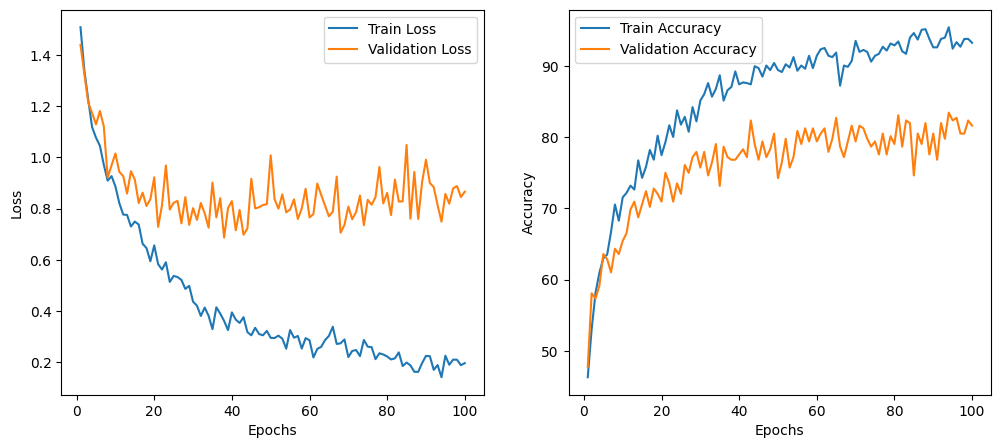

In [25]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1,train_config.num_epochs + 1), train_losses, label = "Train Loss")
plt.plot(range(1, train_config.num_epochs + 1), val_losses, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,train_config.num_epochs + 1), train_accuracies, label = "Train Accuracy")
plt.plot(range(1, train_config.num_epochs + 1), val_accuracies, label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Save the model

In [26]:
model.load_state_dict(torch.load("best.pt"))
model.eval()

CNN(
  (model): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2dNormActivation(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Conv2dNormActivation(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128,

# Inference

In [31]:
def prediction(model, val_loader):

    model.eval()
    model.to(DEVICE)

    all_images, all_labels = [], []
    all_pred_indices, all_pred_probs = [], []

    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.inference_mode():
             outputs = model(images)

        prob = F.softmax(outputs,dim=1)
        pred_indices = prob.data.max(dim=1)[1]
        pred_probs = prob.data.max(dim=1)[0]

        all_images.append(images.cpu())
        all_labels.append(labels.cpu())
        all_pred_indices.append(pred_indices.cpu())
        all_pred_probs.append(pred_probs.cpu())


    return (torch.cat(all_images).numpy(),
            torch.cat(all_labels).numpy(),
            torch.cat(all_pred_indices).numpy(),
            torch.cat(all_pred_probs).numpy())

In [32]:
def denormalize(image):
    mean_ar = np.array(mean)
    std_ar = np.array(std)
    image = image * std_ar + mean_ar
    return image


In [33]:
def visualise_predictions(sample_images,sample_gt_labels, pred_indices, pred_probs, num_images =5):

    fig = plt.figure(figsize = (20,5))

    for i in range(num_images):
        idx = random.randint(0, len(sample_images) -1)
        image = sample_images[idx].transpose(1,2,0) #(C,H,W) --> (H,W,C)
        label = sample_gt_labels[idx]
        pred_idx = pred_indices[idx]
        pred_prob = pred_probs[idx]

        image = denormalize(image)

        ax = fig.add_subplot(1, num_images, i+1)
        ax.imshow(image)
        ax.set_title(f"GT: {class_mapping[label]}\nPred: {class_mapping[pred_idx]} ({pred_prob:.2f})")
        ax.axis('off')

    plt.show()

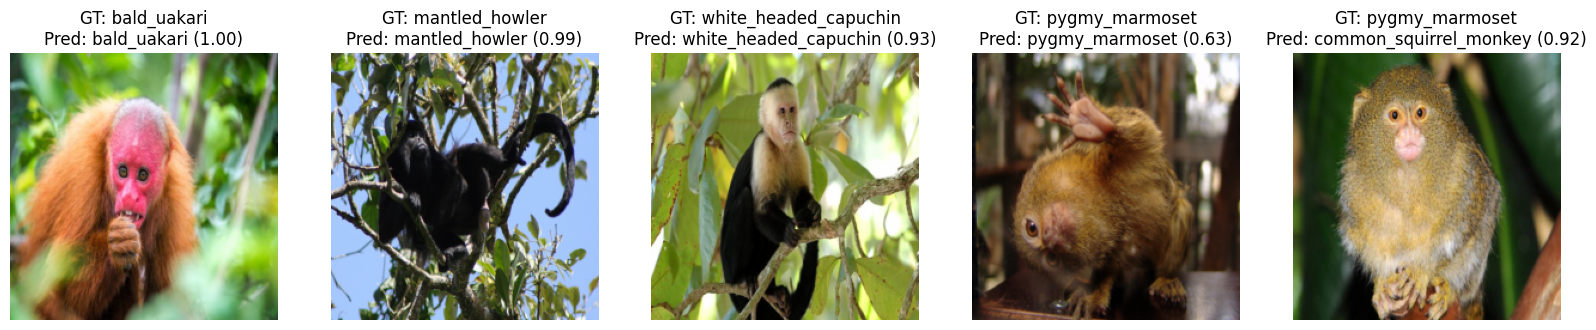

In [34]:
val_images, val_gt_labels, pred_indices, pred_probs = prediction(model, val_loader)

visualise_predictions(val_images, val_gt_labels, pred_indices, pred_probs, num_images = 5)


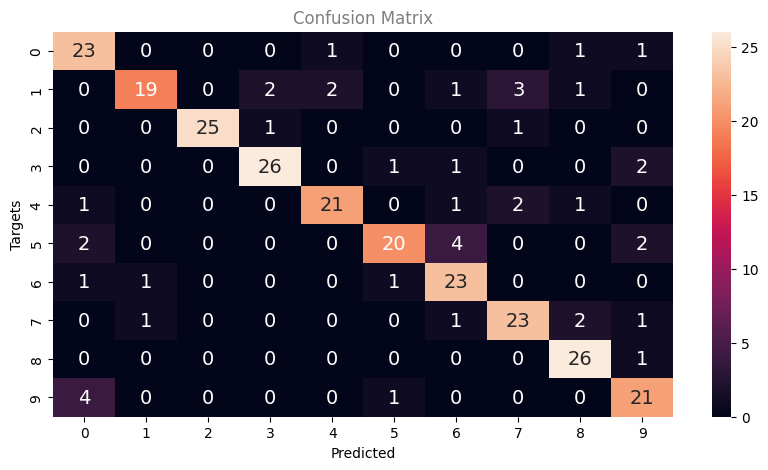

In [35]:
cm = confusion_matrix(y_true=val_gt_labels, y_pred = pred_indices)

plt.figure(figsize= [10,5])
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size":14})
plt.xlabel("Predicted")
plt.ylabel("Targets")
plt.title(f"Confusion Matrix", color="gray")
plt.show()
